# End to end graph generation demo (IEEE)

## Overview

In this notebook, we have walked through the complete process of generating a synthetic dataset based on an IEEE dataset. The IEEE dataset includes information about e-commerce transactions, so it can be iterpret as bipartite graph (user / product) with edge features (transaction info).

Content:

1. [Prepare the original dataset](#1)
1. [Preprare SynGen Configuration](#2)
1. [Dataset Generation](#3)
1. [Tabular data evaluation](#4)
1. [Structure evaluation](#5)

### Imports

In [1]:
# preprocessing
from syngen.preprocessing.datasets import IEEEPreprocessing

# config
from syngen.configuration import SynGenConfiguration

# generation
from syngen.synthesizer import ConfigurationGraphSynthesizer

# evaluation
from syngen.analyzer.tabular import TabularMetrics
from syngen.analyzer.graph import Graph
from syngen.analyzer.graph.stats import get_dd_simmilarity_score
from syngen.analyzer.graph.analyser import AnalysisModule

# utils
import copy
from syngen.utils.types import MetaData

<a id="1"></a>
## Prepare original dataset

SynGen requires the data to be in SynGen dataset format or simply SynGen format, so firstly, we transform the raw Cora dataset into SynGen format. If you don't download IEEE before please follow the instruction in the `scripts/get_datasets.sh`

In [2]:
data_path = '/workspace/data/ieee-fraud'
preprocessed_path = '/workspace/data/ieee_preprocessed'

In [3]:
preprocessing = IEEEPreprocessing(source_path=data_path, destination_path=preprocessed_path)

In [4]:
feature_spec_original = preprocessing.transform(use_cache=True)

In [5]:
feature_spec_original

{'nodes': [{'name': 'user',
   'count': 17090,
   'features': [],
   'features_path': None},
  {'name': 'product', 'count': 197, 'features': [], 'features_path': None}],
 'edges': [{'name': 'user-product',
   'count': 52008,
   'src_node_type': 'user',
   'dst_node_type': 'product',
   'directed': False,
   'features': [{'name': 'TransactionDT',
     'dtype': 'int64',
     'feature_type': 'continuous'},
    {'name': 'TransactionAmt',
     'dtype': 'float64',
     'feature_type': 'continuous'},
    {'name': 'C1', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C2', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C3', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C4', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C5', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C6', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C7', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name'

<a id="2"></a>
## Preprare SynGen Configuration

SynGen generation process is driven by the configuration that is the superset of the SynGen format metadata file. Let us create two configurations: a proper one that will mimic Cora dataset tabular and structural features and a random one.

### Proper Synthetic 

In [6]:
feature_spec_synthetic = feature_spec_original.copy()

feature_spec_synthetic[MetaData.EDGES][0][MetaData.TABULAR_GENERATORS] = [
    {
        MetaData.TYPE: "kde",
        MetaData.FEATURES_LIST: -1, # copies all tabular features
        MetaData.DATA_SOURCE: {
            MetaData.TYPE: 'configuration',
            MetaData.PATH: preprocessed_path,
            MetaData.NAME: "user-product",
        },
        MetaData.PARAMS: {
        }
    }
]

feature_spec_synthetic[MetaData.EDGES][0][MetaData.STRUCTURE_GENERATOR] = {
    MetaData.TYPE: "RMAT",
    MetaData.DATA_SOURCE: {
        MetaData.TYPE: 'cfg', # the same a 'configuration'
        MetaData.PATH: preprocessed_path,
        MetaData.NAME: "user-product",
    },
    MetaData.PARAMS: {
        "has_self_loop": False,
    }
}

# aligns 'TransactionAmt' edge feature based on the 'user-product' edges
feature_spec_synthetic[MetaData.ALIGNERS] = [
    {
        MetaData.TYPE: "xgboost",
        MetaData.GRAPHS: ['user-product'],
        MetaData.NODES: {},
        MetaData.EDGES: {"user-product": ["TransactionAmt"]},
        MetaData.PARAMS: {},
    }
]

config_proper = SynGenConfiguration(feature_spec_synthetic)

In [7]:
config_proper

{<MetaData.EDGES: 'edges'>: [{'name': 'user-product',
   'count': 52008,
   'src_node_type': 'user',
   'dst_node_type': 'product',
   'directed': False,
   'features': [{'name': 'TransactionDT',
     'dtype': 'int64',
     'feature_type': 'continuous'},
    {'name': 'TransactionAmt',
     'dtype': 'float64',
     'feature_type': 'continuous'},
    {'name': 'C1', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C2', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C3', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C4', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C5', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C6', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C7', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C8', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C9', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C10', 'dt

### Random 

In [8]:
feature_spec_random = feature_spec_original.copy() 

feature_spec_random[MetaData.EDGES][0][MetaData.TABULAR_GENERATORS] = [
    {
        MetaData.TYPE: "random",
        MetaData.FEATURES_LIST: -1, # copies all tabular features
        MetaData.DATA_SOURCE: {
            MetaData.TYPE: 'random',
        },
        MetaData.PARAMS: {
        }
    }
]

feature_spec_random[MetaData.EDGES][0][MetaData.STRUCTURE_GENERATOR] = {
    MetaData.TYPE: "RMAT",
    MetaData.DATA_SOURCE: {
        MetaData.TYPE: 'rnd', # the save as 'random' 
    },
    MetaData.PARAMS: {
        "has_self_loop": False,
    }
}

config_random = SynGenConfiguration(feature_spec_random)

In [9]:
config_random

{<MetaData.EDGES: 'edges'>: [{'name': 'user-product',
   'count': 52008,
   'src_node_type': 'user',
   'dst_node_type': 'product',
   'directed': False,
   'features': [{'name': 'TransactionDT',
     'dtype': 'int64',
     'feature_type': 'continuous'},
    {'name': 'TransactionAmt',
     'dtype': 'float64',
     'feature_type': 'continuous'},
    {'name': 'C1', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C2', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C3', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C4', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C5', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C6', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C7', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C8', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C9', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C10', 'dt

<a id="3"></a>
## Dataset Generation

In [10]:
save_path_proper = '/workspace/data/ieee_generated'
save_path_random = '/workspace/data/ieee_random'

### Create Synthesizers

In [11]:
synthesizer_proper = ConfigurationGraphSynthesizer(configuration=config_proper, save_path=save_path_proper, gpu=True)
synthesizer_random = ConfigurationGraphSynthesizer(configuration=config_random, save_path=save_path_random, gpu=True)

### Fit Synthesizers

In [12]:
synthesizer_proper.fit()

In [13]:
synthesizer_random.fit()

### Generation

In [14]:
feature_spec_generated_proper = synthesizer_proper.generate()

In [15]:
feature_spec_generated_proper

{<MetaData.EDGES: 'edges'>: [{'name': 'user-product',
   'count': 52008,
   'src_node_type': 'user',
   'dst_node_type': 'product',
   'directed': False,
   'features': [{'name': 'TransactionDT',
     'dtype': 'int64',
     'feature_type': 'continuous'},
    {'name': 'TransactionAmt',
     'dtype': 'float64',
     'feature_type': 'continuous'},
    {'name': 'C1', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C2', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C3', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C4', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C5', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C6', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C7', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C8', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C9', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C10', 'dt

In [16]:
feature_spec_generated_random = synthesizer_random.generate()

In [17]:
feature_spec_generated_random

{<MetaData.EDGES: 'edges'>: [{'name': 'user-product',
   'count': 52008,
   'src_node_type': 'user',
   'dst_node_type': 'product',
   'directed': False,
   'features': [{'name': 'TransactionDT',
     'dtype': 'int64',
     'feature_type': 'continuous'},
    {'name': 'TransactionAmt',
     'dtype': 'float64',
     'feature_type': 'continuous'},
    {'name': 'C1', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C2', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C3', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C4', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C5', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C6', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C7', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C8', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C9', 'dtype': 'float64', 'feature_type': 'continuous'},
    {'name': 'C10', 'dt

<a id="4"></a>
## Tabular Data Evaluation

In [18]:
original_tabular_data, categorical_features = feature_spec_original.get_tabular_data(MetaData.EDGES, 'user-product', return_cat_feats=True)

In [19]:
proper_tabular_data = feature_spec_generated_proper.get_tabular_data(MetaData.EDGES, 'user-product')

In [20]:
random_tabular_data = feature_spec_generated_random.get_tabular_data(MetaData.EDGES, 'user-product')

In [21]:
tab_eval = TabularMetrics(original_tabular_data, 
                          proper_tabular_data, 
                          categorical_columns=categorical_features)

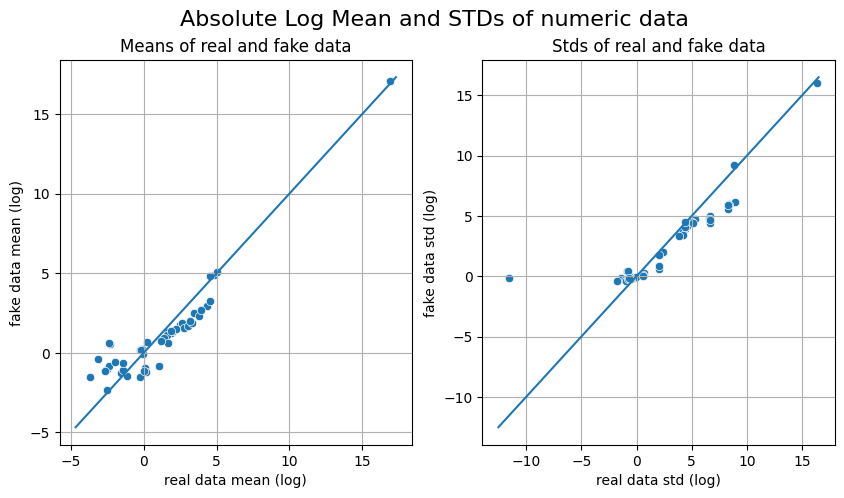

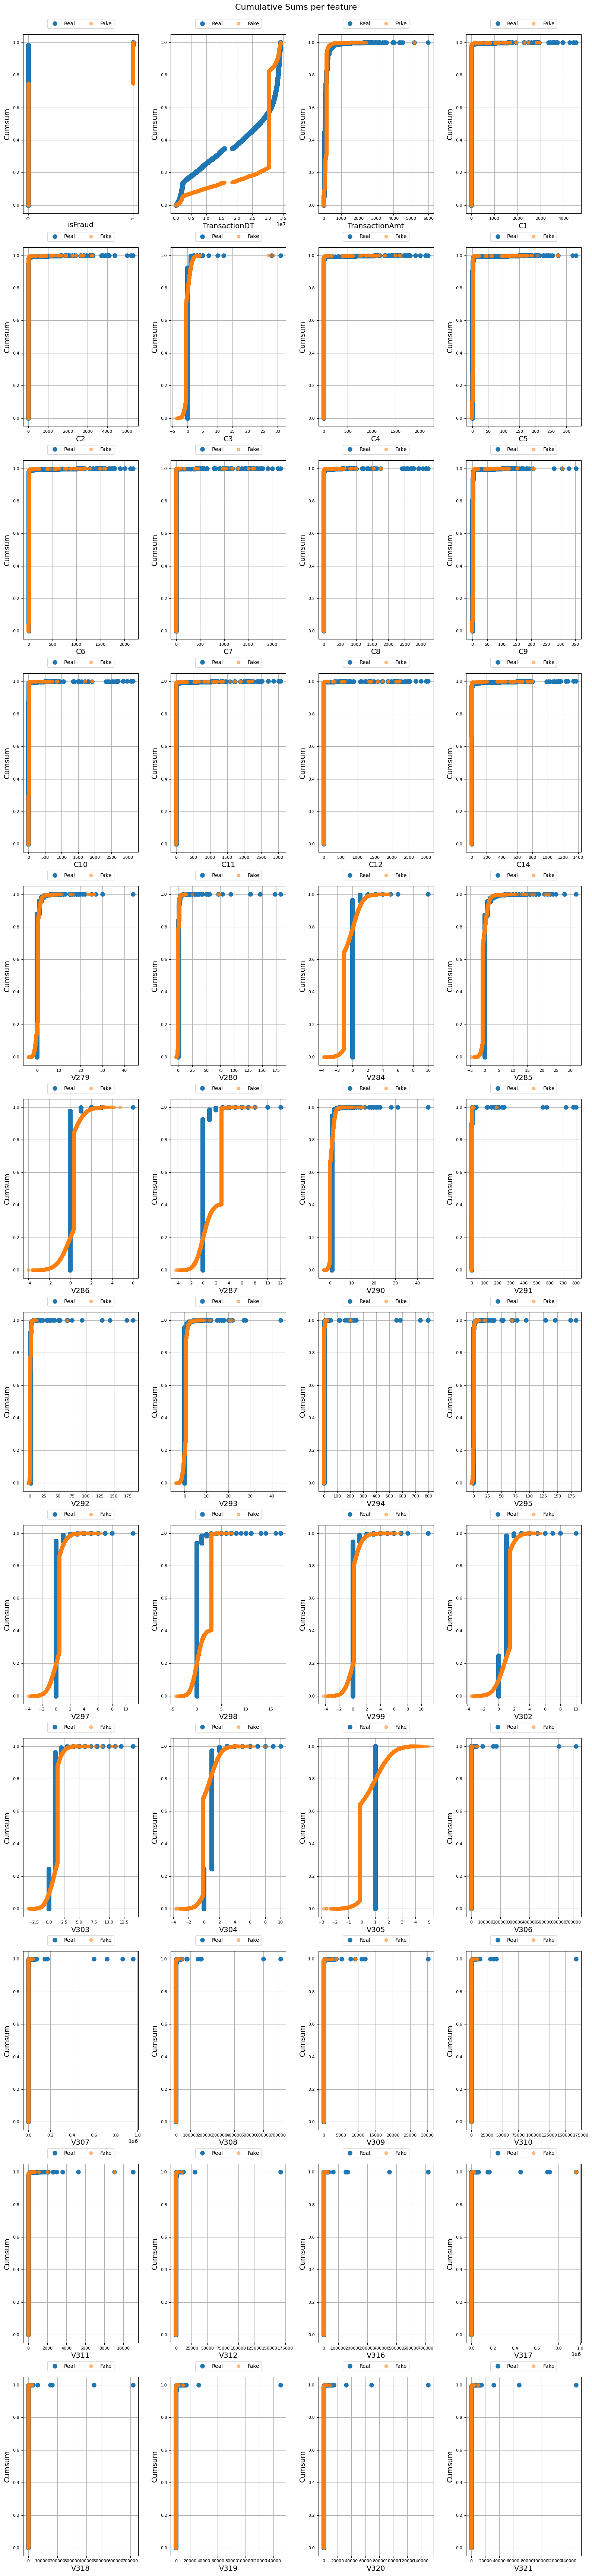

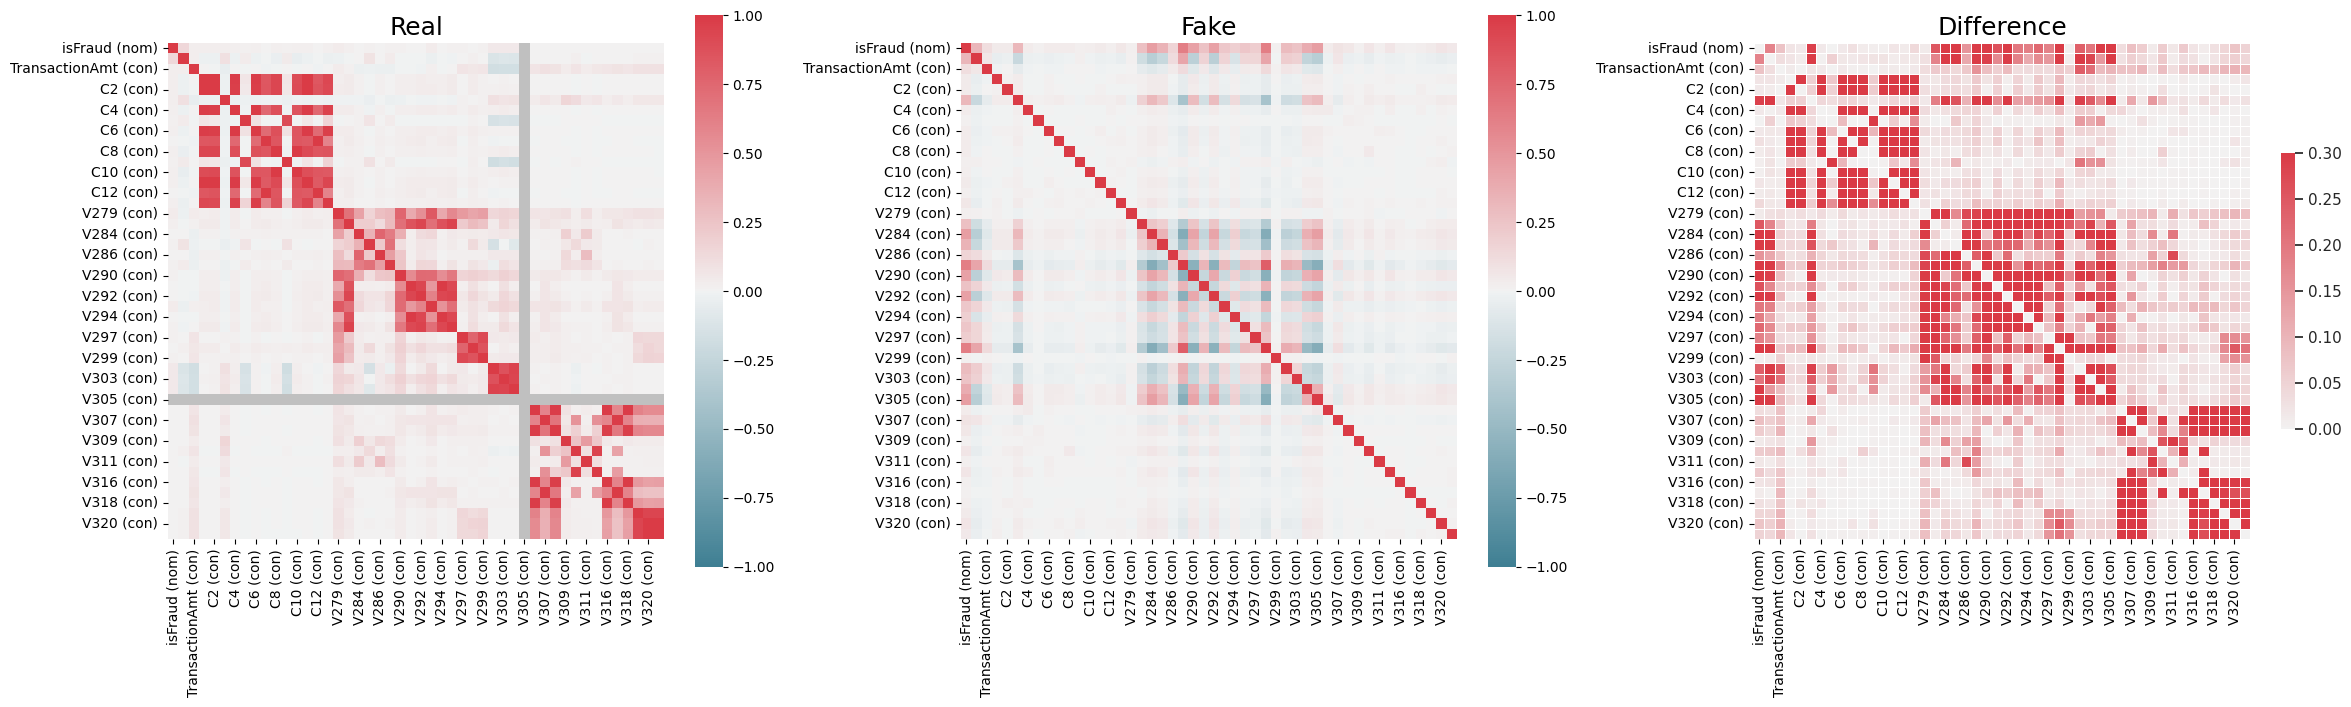

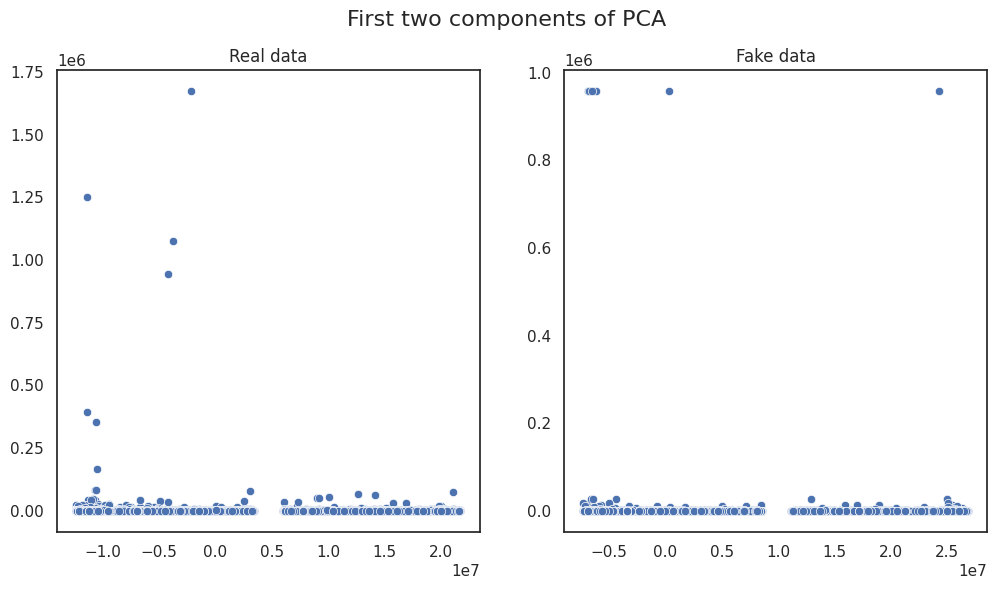

In [22]:
tab_eval.visual_evaluation()

In [23]:
tab_eval = TabularMetrics(original_tabular_data, 
                          random_tabular_data, 
                          categorical_columns=categorical_features)

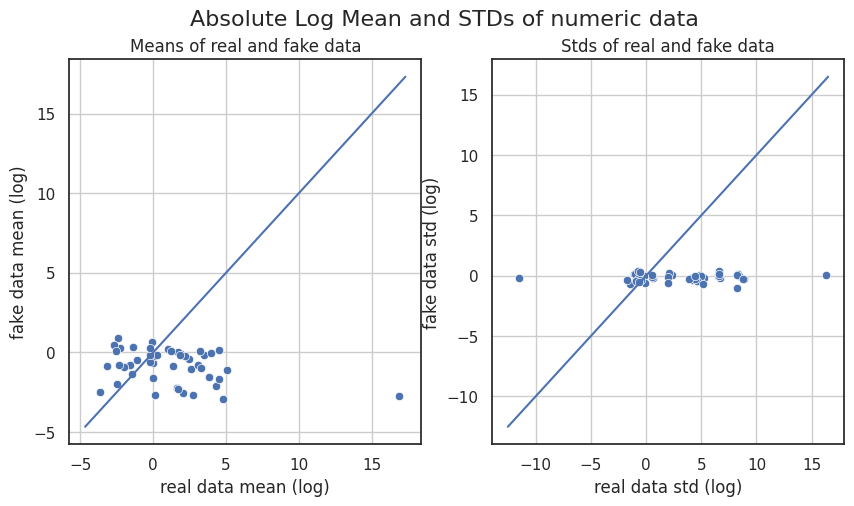

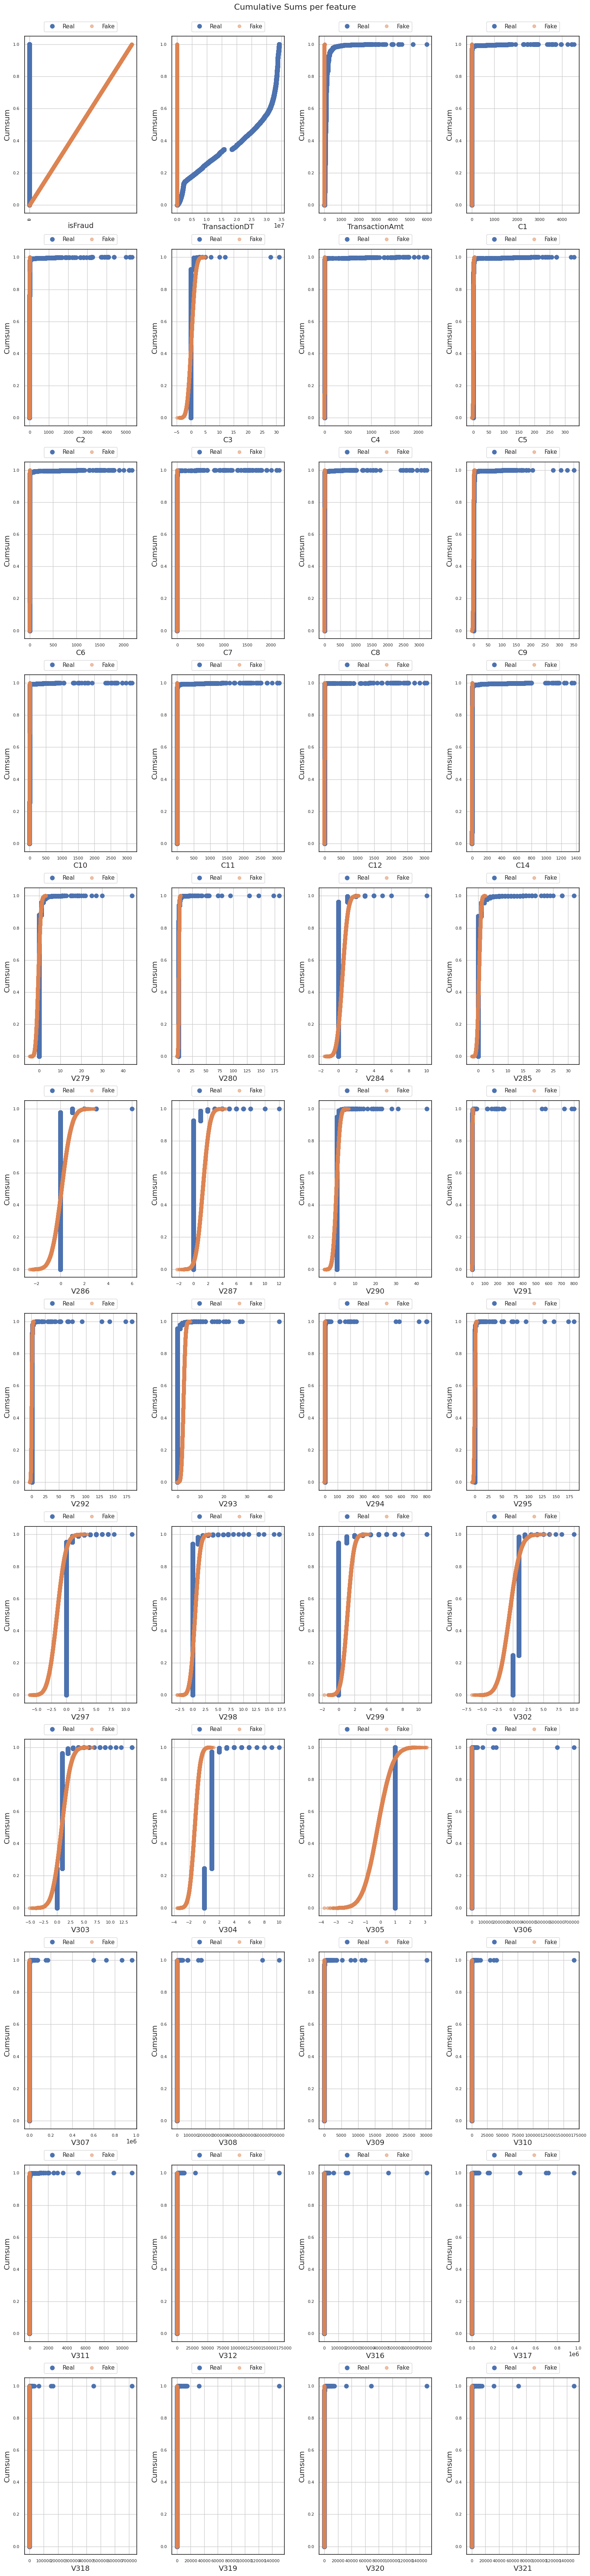

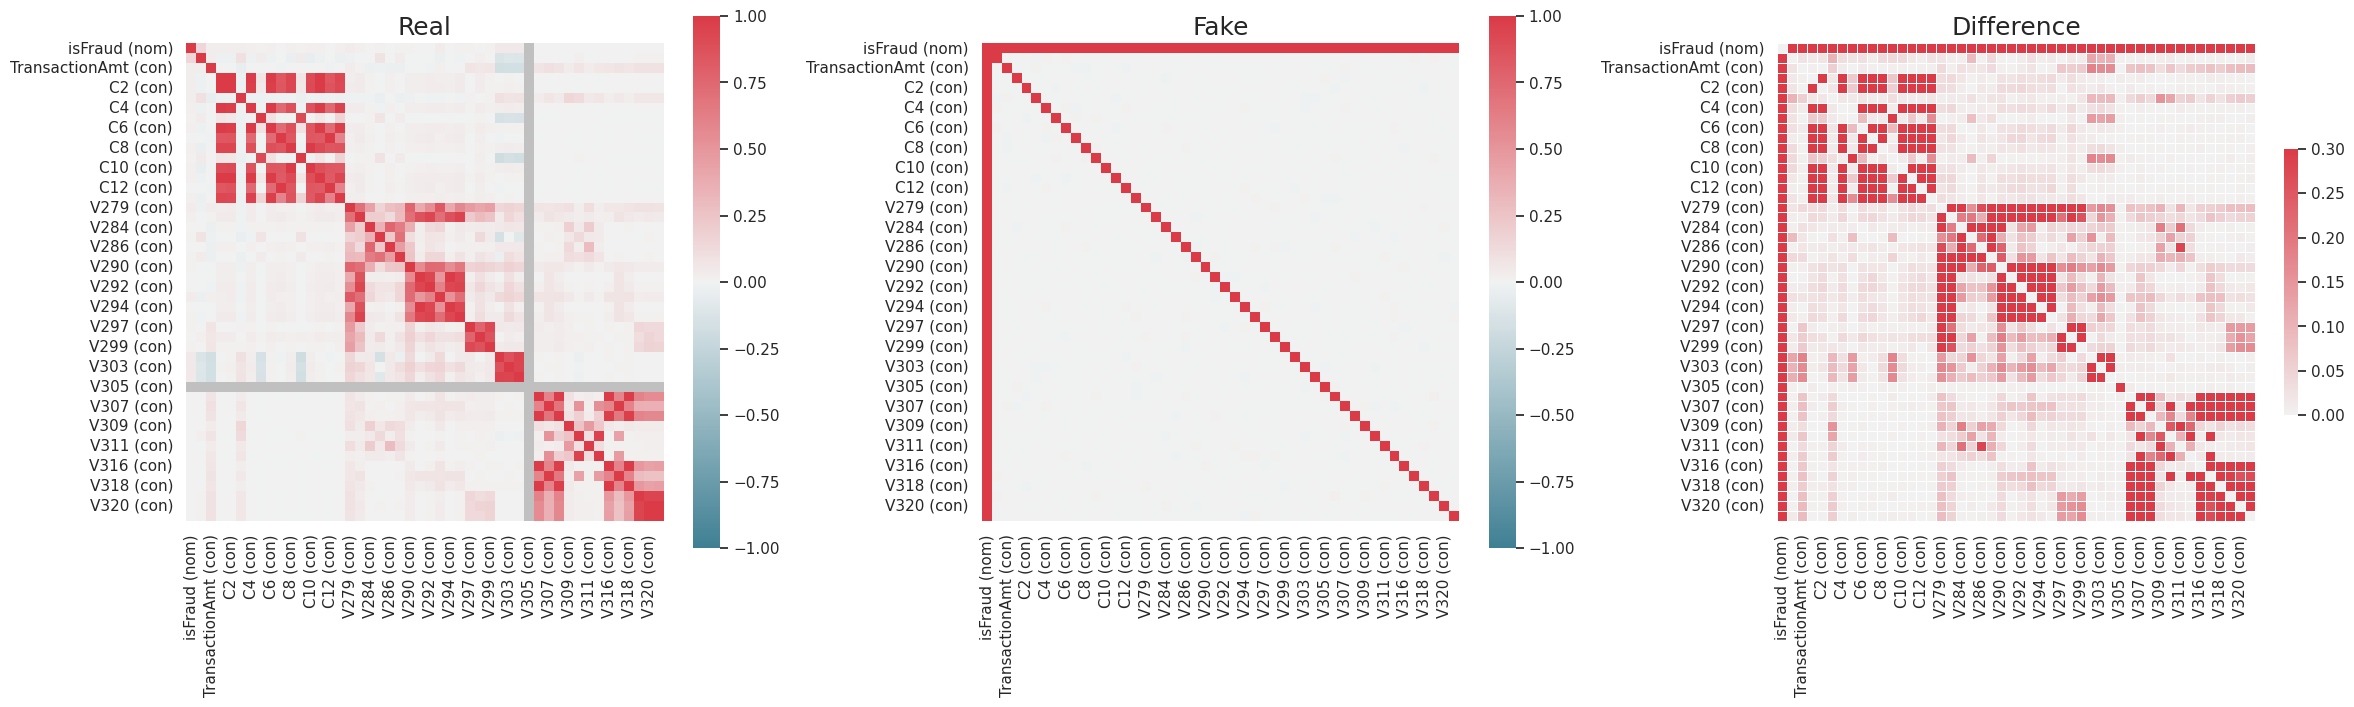

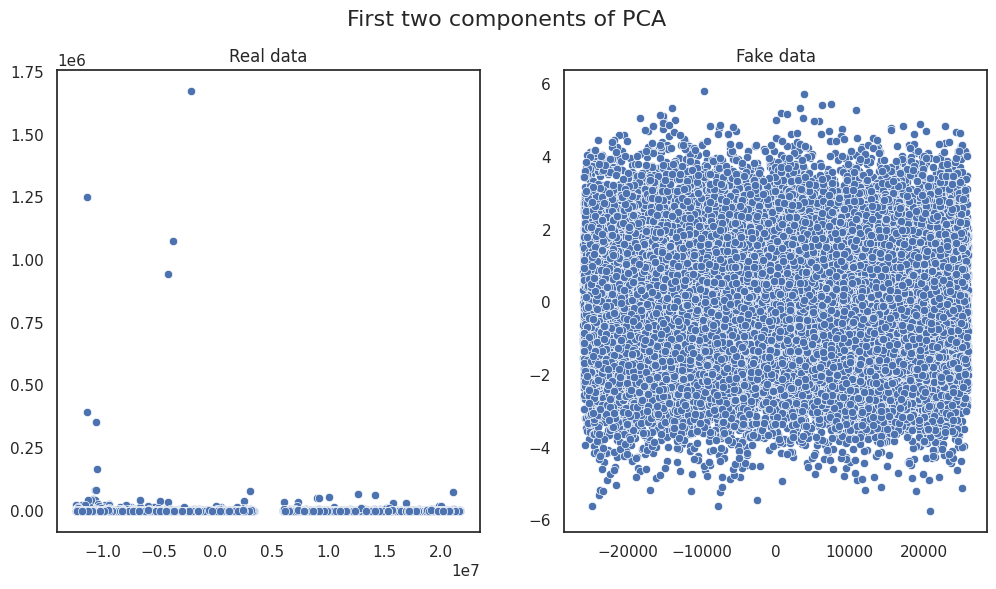

In [24]:
tab_eval.visual_evaluation()

<a id="5"></a>
## Structute Evaluation

In [25]:
original_graph_structure = feature_spec_original.get_structural_data('user-product')
proper_graph_structure = feature_spec_generated_proper.get_structural_data('user-product')
random_graph_structure = feature_spec_generated_random.get_structural_data('user-product')

In [26]:
orig_proper = get_dd_simmilarity_score(original_graph_structure, proper_graph_structure, cdf_points=1000)
orig_random = get_dd_simmilarity_score(original_graph_structure, random_graph_structure, cdf_points=1000)

print("DEGREE SIMILLARITY SCORE")
print("ORIG vs PROPER:", orig_proper)
print("ORIG vs RANDOM:", orig_random)

DEGREE SIMILLARITY SCORE
ORIG vs PROPER: 0.9369674422689857
ORIG vs RANDOM: 0.9685419233777225


In [27]:
original_snap_graph = Graph.instantiate_from_feature_spec(feature_spec_original, 'user-product', graph_name='original')
proper_snap_graph = Graph.instantiate_from_feature_spec(feature_spec_generated_proper, 'user-product', graph_name='properly_generated')
random_graph_structure = Graph.instantiate_from_feature_spec(feature_spec_generated_random, 'user-product', graph_name='randomly_generated')
all_graphs = [original_snap_graph, proper_snap_graph, random_graph_structure]

In [28]:
graph_analyser = AnalysisModule()

In [29]:
df = graph_analyser.compare_graph_stats(*all_graphs)
df

,Category,Statistic,original,properly_generated,randomly_generated
0,Global stats,Nodes,17287,17346,17346
1,Global stats,Edges,52007,51536,52005
2,Global stats,Density,0.0003,0.0003,0.0003
3,Global stats,Average degree,3.01,2.97,3.0
4,Global stats,Zero deg nodes,196,10254,2822
5,Global stats,Zero in deg nodes,196,10254,2822
6,Global stats,Zero out deg nodes,196,10254,2822
7,Global stats,Self loops,0,35,2
8,Global stats,Bidirectional edges,52007,51501,52003
9,Global stats,Unique undirected edges,52007,51501,52003


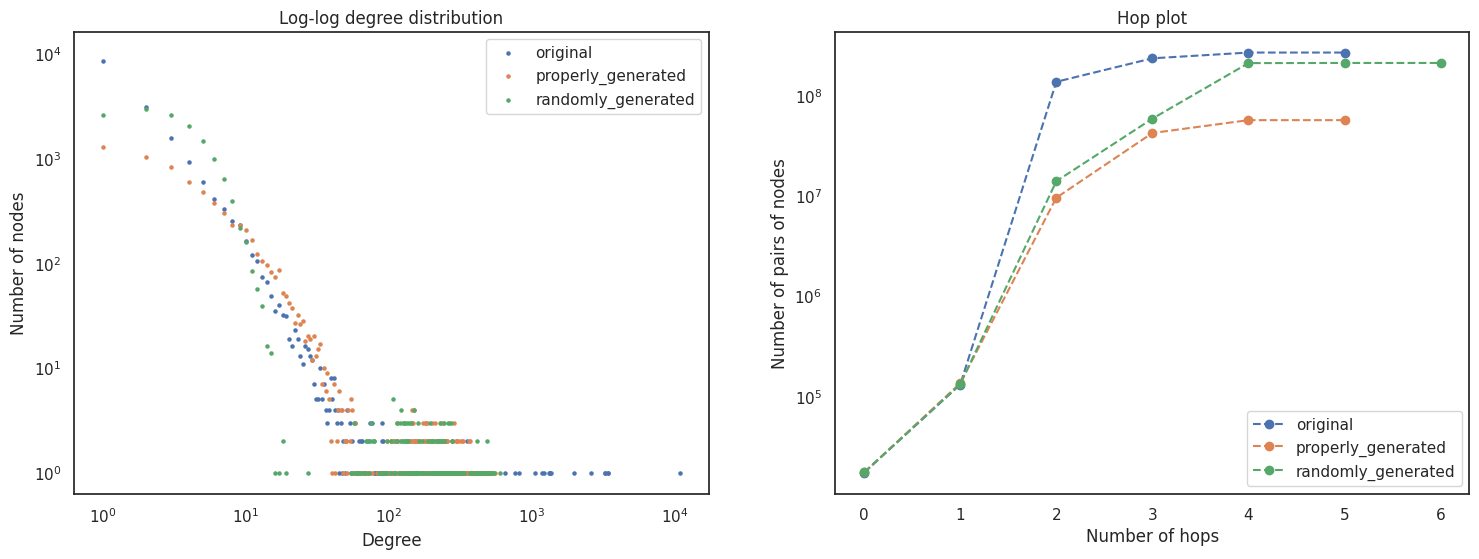

In [30]:
from matplotlib.pyplot import set_loglevel
set_loglevel('warning')
_ = graph_analyser.compare_graph_plots(*all_graphs)